<center>
    
# Анализ временных рядов на примере прогнозирования спроса наличности в банкоматах

Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, через равные промежутки

In [1]:
import sys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

Количество игроков в онлайне одной из мобильных игр

In [2]:
dataset = pd.read_csv('./data/lecture1/hour_online.csv', index_col=['Time'], parse_dates=['Time'])
dataset.head()

Users
Time                      
2017-01-01 00:00:00  34002
2017-01-01 01:00:00  37947
2017-01-01 02:00:00  41517
2017-01-01 03:00:00  44476
2017-01-01 04:00:00  46234

In [3]:
plotly_df(dataset, title = "Online users")

__Скользящее среднее__ 

$\widehat{y}_{t} = \frac{1}{n} \displaystyle\sum_{k=1}^{n} y_{t-k}$

In [4]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.Users, 24)

29858.333333333332

In [5]:
plotly_df(dataset[-24:])

In [6]:
def plotMovingAverage(series, n):
    
    rolling_mean = series.rolling(window=n).mean().shift(1)
    
    rolling_std =  series.rolling(window=n).std().shift(1)
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std
    
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(series[n+1:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

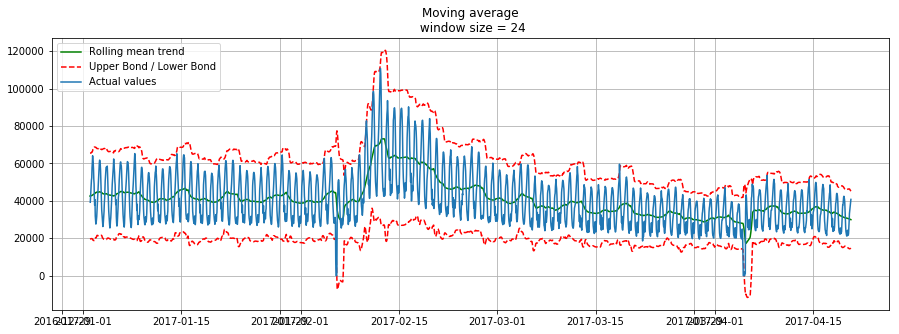

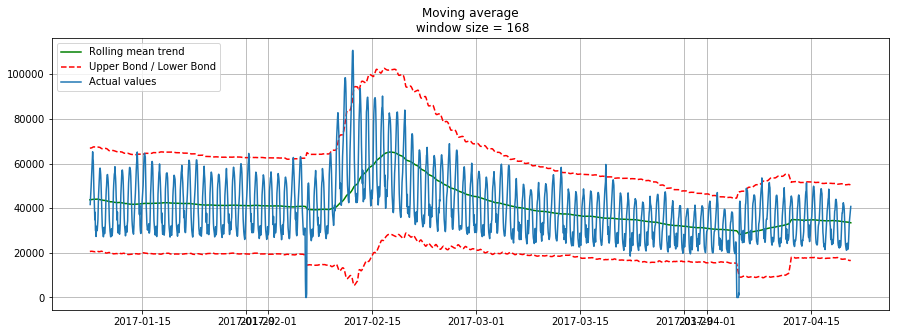

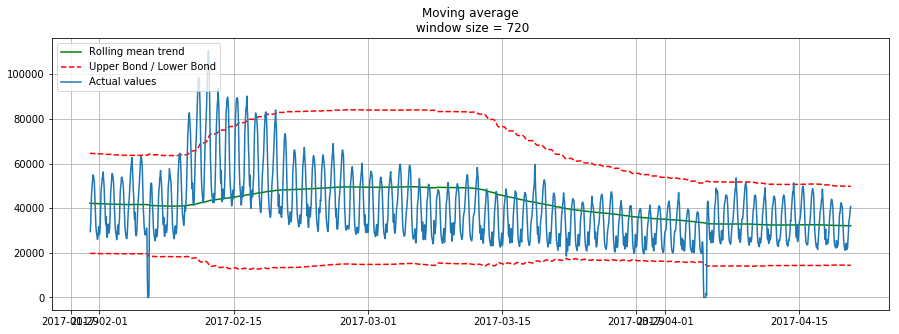

In [7]:
plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям
plotMovingAverage(dataset, 24*30) # сглаживаем по месяцам

__Взвешенное скользящее среднее__


$\widehat{y}_{t} = \displaystyle\sum_{k=1}^n \omega_k y_{t-k}$

In [8]:
dataset.Users[-5:]

Time
2017-04-20 05:00:00    34833
2017-04-20 06:00:00    35932
2017-04-20 07:00:00    38418
2017-04-20 08:00:00    40238
2017-04-20 09:00:00    40763
Name: Users, dtype: int64

In [9]:
np.average(dataset.Users[-6:-1], weights=[0.03, 0.07, 0.1, 0.2, 0.6])

38854.51

In [10]:
dataset.Users[-5:]

Time
2017-04-20 05:00:00    34833
2017-04-20 06:00:00    35932
2017-04-20 07:00:00    38418
2017-04-20 08:00:00    40238
2017-04-20 09:00:00    40763
Name: Users, dtype: int64

In [11]:
plotly_df(dataset[-5:])

__Экспоненциальное сглаживание__

$${\ell}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot {\ell}_{t-1}$$
$$\ell_0 = y_0$$


$$\widehat{y}_{t+1} = {\ell}_t$$


In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)-1):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return [np.nan]+result

In [13]:
alpha1 = 0.3
alpha2 = 0.05
df = pd.concat([dataset,
                pd.DataFrame(exponential_smoothing(dataset.Users, alpha1), index=dataset.index), 
                pd.DataFrame(exponential_smoothing(dataset.Users, alpha2), index=dataset.index)], axis=1)
df.columns=['Actual', 'Alpha = ' + str(alpha1), 'Alpha = ' + str(alpha2)]

In [14]:
plotly_df(df, title = "Exponential Smooting")

__Двойное экспоненциальное сглаживание__

$\ell_t = \alpha y_t + (1-\alpha)(\ell_{t-1} + b_{t-1})$

$b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$

$\widehat{y}_{t+m} = \ell_t + m \cdot b_t$


In [15]:
def double_exponential_smoothing(series, alpha, beta):
    level, trend = series[0], 0
    result = [level + trend]
    for n in range(1, len(series)-1):
        last_level, level = level, alpha*series[n] + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append((level+trend) if level+trend >= 0 else 0)
    return [np.nan]+result

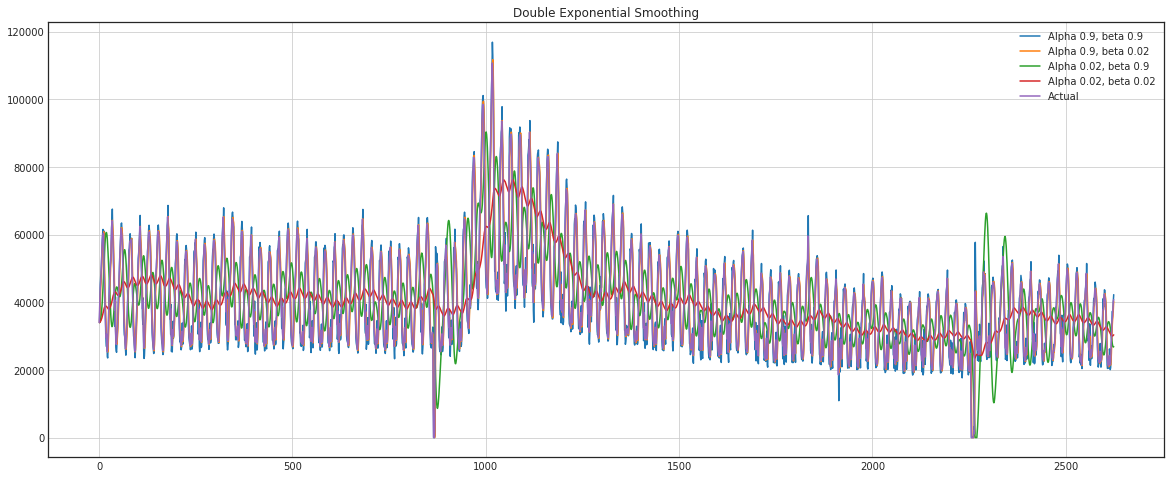

In [16]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Для онлайн-игры

In [17]:
df = pd.concat([pd.DataFrame(dataset.Users),
                pd.DataFrame(exponential_smoothing(dataset.Users, 0.6), index=dataset.Users.index),
                pd.DataFrame(double_exponential_smoothing(dataset.Users, 0.6, 0.2), index=dataset.Users.index)], axis=1)
df.columns=['Actual', 'Smoothing', 'Double Smoothing']

In [18]:
plotly_df(df, title='Сравнение двух методов')

In [19]:
roll_days=10
mae_smooting=np.abs(df['Actual']-df['Smoothing']).rolling(roll_days).mean().dropna()
mae_double_smooting=np.abs(df['Actual']-df['Double Smoothing']).rolling(roll_days).mean().dropna()

In [20]:
df_mae = pd.concat([mae_smooting, mae_double_smooting], axis=1)
df_mae.columns = ['MAE_SMOTHING', 'MAE_DOUBLE_SMOOTING']
plotly_df(df_mae, title='Скользящее MAE')

## Тройное экспоненциальное сглаживание (известное также как модель Хольта-Винтерса)

$\ell_t = \alpha(y_t - s_{t-L}) + (1-\alpha)(\ell_{t-1} + b_{t-1})$


$b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$

$s_t = \gamma(y_t - \ell_t) + (1-\gamma)s_{t-L}$

$\widehat{y}_{t+m} = \ell_t + m \cdot b_t + s_{t-L+1+(m-1)modL}$

In [ ]:
#from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

In [23]:
class HoltWinters:
    
    """
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала(обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        summ = 0.0
        for i in range(self.slen):
            summ += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return summ / self.slen
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])    

__Кросс-валидация на временных рядах__

from sklearn.model_selection import TimeSeriesSplit

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

In [24]:
alpha_final = 0.006635880294816432
beta_final = 0
gamma_final = 0.046569454900318885

Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 5 дней вперёд (128 часов)

In [25]:
# Передаем оптимальные значения модели, 
data = dataset.Users
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

Код для отрисовки графика

In [26]:
def plotHoltWinters():
    plt.figure(figsize=(25, 10))
    plt.plot(data.values, label = "Actual")
    plt.plot(model.result, label = "Model")
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

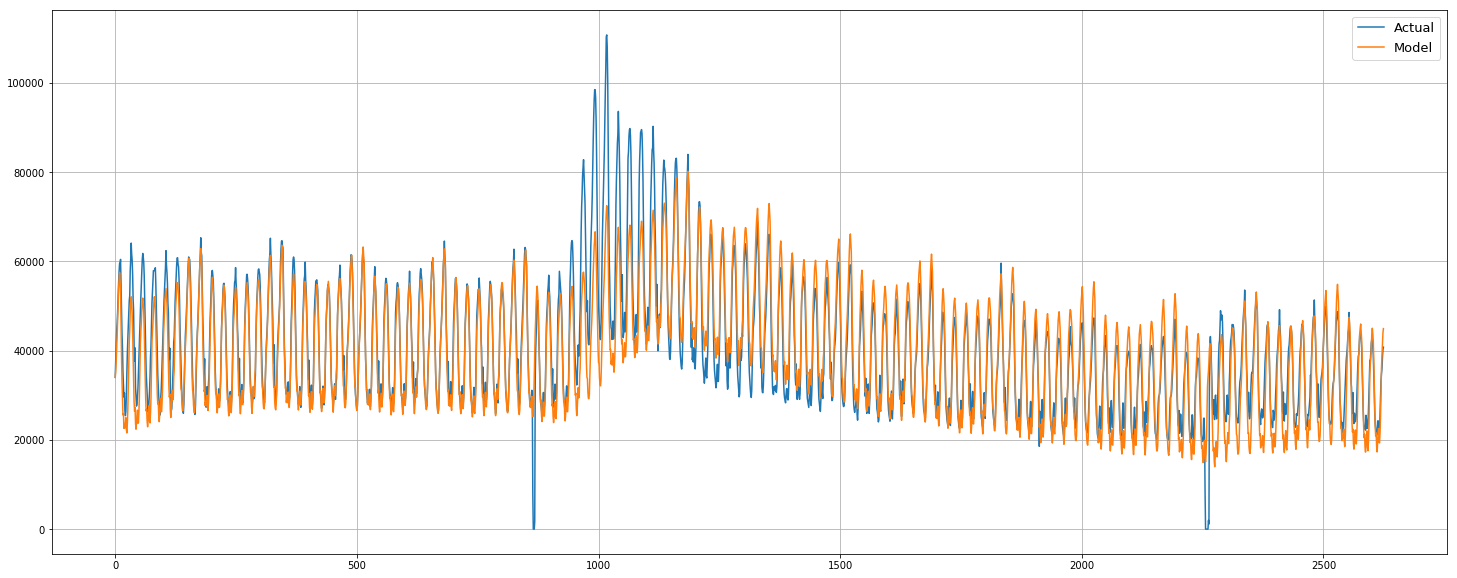

In [27]:
plotHoltWinters()

In [28]:
df_holt = pd.concat([pd.DataFrame(data.values, index=data.index),
                     pd.DataFrame(model.result, index=data.index)], axis=1)
df_holt.columns=['Actual', 'HoltWinters']

In [29]:
plotly_df(df_holt, title='HoltWinters')

___Линейные (и не только) модели на временных рядах___

__Извлечение признаков (Feature exctraction)__

tsfresh - автоматически генерируем признаки из временных рядов

https://otus.ru/nest/post/1024/?ysclid=l5eemrbp5u999654461

In [30]:
data = dataset.copy()
data.columns = ['y']
data.index = pd.to_datetime(data.index)

In [31]:
data.head()

y
Time                      
2017-01-01 00:00:00  34002
2017-01-01 01:00:00  37947
2017-01-01 02:00:00  41517
2017-01-01 03:00:00  44476
2017-01-01 04:00:00  46234

In [32]:
hour_dummy_df = pd.get_dummies(data.index.hour, prefix='hour').set_index(data.index)
weekday_dummy_df = pd.get_dummies(data.index.weekday, prefix='weekday').set_index(data.index)
is_weekend_dummy_df = pd.get_dummies(data.index.weekday.isin([5,6]) * 1, prefix='is_weekend').set_index(data.index)
features_dummy_df = pd.concat([data, hour_dummy_df, weekday_dummy_df, is_weekend_dummy_df], axis=1, join='inner')

In [33]:
pd.set_option('max_columns', 100)

In [34]:
features_dummy_df.head()

y  hour_0  hour_1  hour_2  hour_3  hour_4  hour_5  \
Time                                                                         
2017-01-01 00:00:00  34002       1       0       0       0       0       0   
2017-01-01 01:00:00  37947       0       1       0       0       0       0   
2017-01-01 02:00:00  41517       0       0       1       0       0       0   
2017-01-01 03:00:00  44476       0       0       0       1       0       0   
2017-01-01 04:00:00  46234       0       0       0       0       1       0   

                     hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  \
Time                                                                    
2017-01-01 00:00:00       0       0       0       0        0        0   
2017-01-01 01:00:00       0       0       0       0        0        0   
2017-01-01 02:00:00       0       0       0       0        0        0   
2017-01-01 03:00:00       0       0       0       0        0        0   
2017-01-01 04:00:00       0       0       0       0        0        0   

                     hour_12  hour_13  hour_14  hour_15  hour_16  hour_17  \
Time                                                                        
2017-01-01 00:00:00        0        0        0        0        0        0   
2017-01-01 01:00:00        0        0        0        0        0        0   
2017-01-01 02:00:00        0        0        0        0        0        0   
2017-01-01 03:00:00        0        0        0        0        0        0   
2017-01-01 04:00:00        0        0        0        0        0        0   

                     hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  \
Time                                                                        
2017-01-01 00:00:00        0        0        0        0        0        0   
2017-01-01 01:00:00        0        0        0        0        0        0   
2017-01-01 02:00:00        0        0        0        0        0        0   
2017-01-01 03:00:00        0        0        0        0        0        0   
2017-01-01 04:00:00        0        0        0        0        0        0   

                     weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
Time                                                                         
2017-01-01 00:00:00          0          0          0          0          0   
2017-01-01 01:00:00          0          0          0          0          0   
2017-01-01 02:00:00          0          0          0          0          0   
2017-01-01 03:00:00          0          0          0          0          0   
2017-01-01 04:00:00          0          0          0          0          0   

                     weekday_5  weekday_6  is_weekend_0  is_weekend_1  
Time                                                                   
2017-01-01 00:00:00          0          1             0             1  
2017-01-01 01:00:00          0          1             0             1  
2017-01-01 02:00:00          0          1             0             1  
2017-01-01 03:00:00          0          1             0             1  
2017-01-01 04:00:00          0          1             0             1

Можно извлечь напрямую

In [35]:
features_df = data

In [36]:
features_df['hour'] = features_df.index.hour
features_df['weekday'] = features_df.index.weekday
features_df['is_weekend'] = features_df.weekday.isin([5,6])*1
features_df.head()

y  hour  weekday  is_weekend
Time                                                 
2017-01-01 00:00:00  34002     0        6           1
2017-01-01 01:00:00  37947     1        6           1
2017-01-01 02:00:00  41517     2        6           1
2017-01-01 03:00:00  44476     3        6           1
2017-01-01 04:00:00  46234     4        6           1

Как добавить, например, среднее по дням недели

In [37]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

Посмотрим на средние по дням недели

In [38]:
code_mean(data, 'weekday', 'y')

{0: 38730.143229166664,
 1: 38632.828125,
 2: 38128.518229166664,
 3: 39519.035135135135,
 4: 41505.15277777778,
 5: 43717.708333333336,
 6: 43392.14360313316}

In [39]:
def prepare_data(data, lags, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ['y']
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for ll in lags:
        data['lag_{}'.format(ll)] = data.y.shift(ll)
        
    
    #data.index = data.index.to_datetime()
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', 'y').get, data.weekday))
    data['hour_average'] = list(map(code_mean(data[:test_index], 'hour', 'y').get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(['hour', 'weekday'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

In [43]:
X_train

lag_1    lag_2    lag_3  is_weekend  weekday_average  hour_average
0     41517.0  37947.0  34002.0           1     47361.657795  44208.467532
1     44476.0  41517.0  37947.0           1     47361.657795  50026.142857
2     46234.0  44476.0  41517.0           1     47361.657795  53812.779221
3     48842.0  46234.0  44476.0           1     47361.657795  56388.610390
4     52245.0  48842.0  46234.0           1     47361.657795  59498.285714
...       ...      ...      ...         ...              ...           ...
1833  48286.0  53031.0  59581.0           1     47773.740157  48084.168831
1834  44252.0  48286.0  53031.0           1     47773.740157  42724.236842
1835  39370.0  44252.0  48286.0           1     47773.740157  37372.223684
1836  36440.0  39370.0  44252.0           1     47773.740157  34212.605263
1837  30674.0  36440.0  39370.0           1     47773.740157  34159.921053

[1838 rows x 6 columns]

Обучим на получившихся данных простую линейную регрессию. 

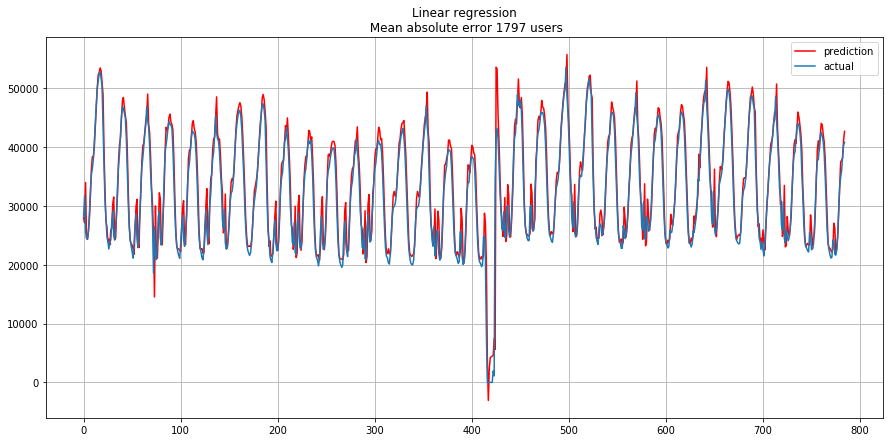

In [44]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepare_data(dataset.Users, lags = [1,2,3], test_size=0.3)
model = LinearRegression(normalize=False)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True)

In [45]:
X_train

lag_1    lag_2    lag_3  is_weekend  weekday_average  hour_average
0     41517.0  37947.0  34002.0           1     47361.657795  44208.467532
1     44476.0  41517.0  37947.0           1     47361.657795  50026.142857
2     46234.0  44476.0  41517.0           1     47361.657795  53812.779221
3     48842.0  46234.0  44476.0           1     47361.657795  56388.610390
4     52245.0  48842.0  46234.0           1     47361.657795  59498.285714
...       ...      ...      ...         ...              ...           ...
1833  48286.0  53031.0  59581.0           1     47773.740157  48084.168831
1834  44252.0  48286.0  53031.0           1     47773.740157  42724.236842
1835  39370.0  44252.0  48286.0           1     47773.740157  37372.223684
1836  36440.0  39370.0  44252.0           1     47773.740157  34212.605263
1837  30674.0  36440.0  39370.0           1     47773.740157  34159.921053

[1838 rows x 6 columns]

Посмотрим, какие лаги действительно значимые

In [46]:
y_train_series = pd.Series(data=np.array(y_train), index=dataset.Users.index[:len(y_train)])

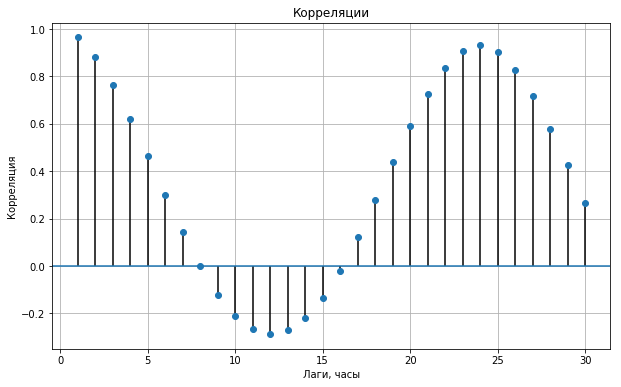

In [47]:
n_lags = 30
corr_list = []
for i_lag in range(1,n_lags+1):
    corr_list.append(np.corrcoef(y_train_series[i_lag:], y_train_series.shift(i_lag)[i_lag:])[0,1])
plt.figure(figsize=(10,6))
plt.vlines(range(1, n_lags+1), [0], corr_list)
plt.axhline()
plt.plot(range(1, n_lags+1), corr_list, 'o')
plt.title('Корреляции')
plt.xlabel('Лаги, часы')   
plt.ylabel('Корреляция')
plt.grid(True)
plt.show()

In [48]:
all_data=pd.read_csv('./data/lecture1/atm_data_train.csv', index_col=0, parse_dates=True)
all_data.index=pd.to_datetime(all_data.index)

869273


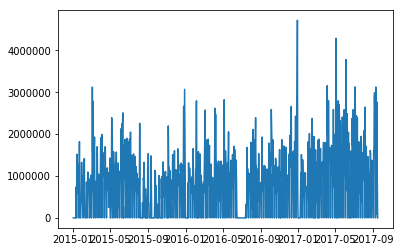

785116


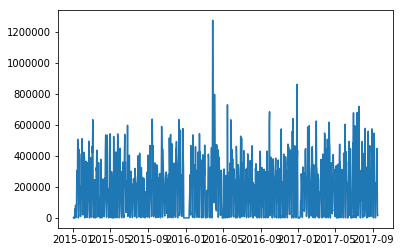

786314


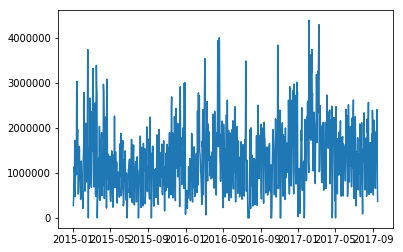

786676


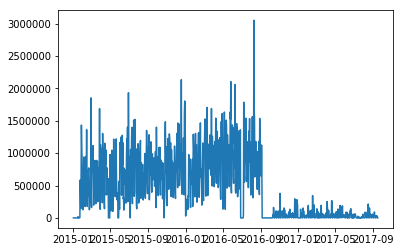

791711


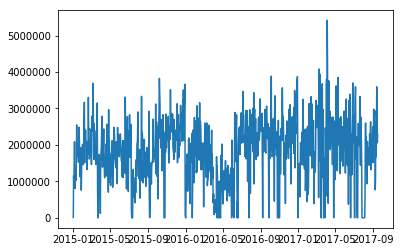

791712


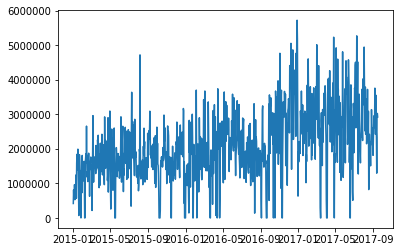

794249


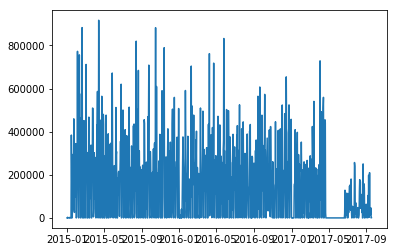

794287


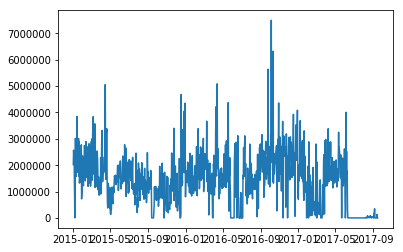

794288


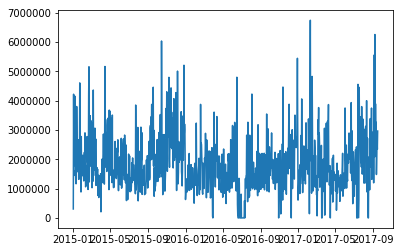

794289


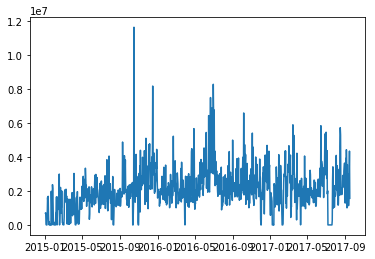

794989


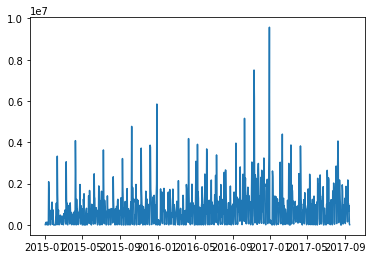

785115


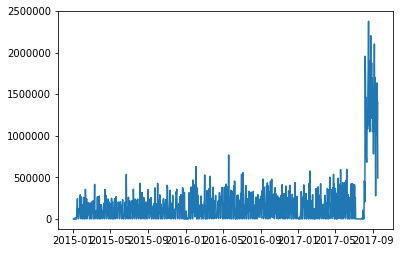

794992


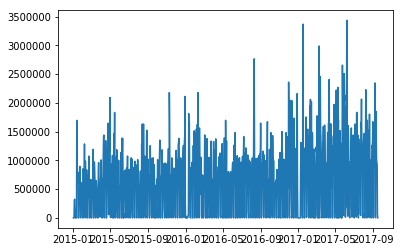

796427


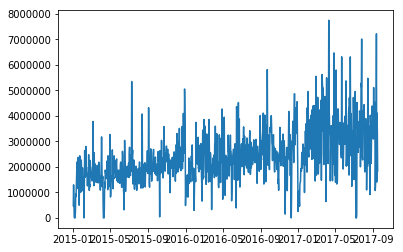

796428


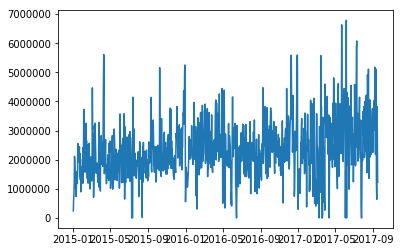

797235


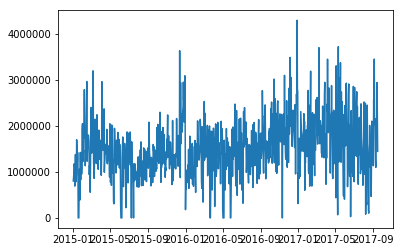

798092


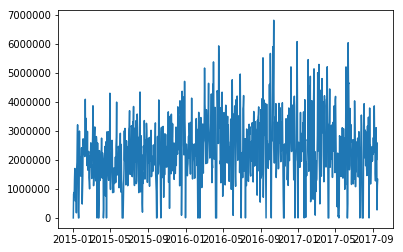

798105


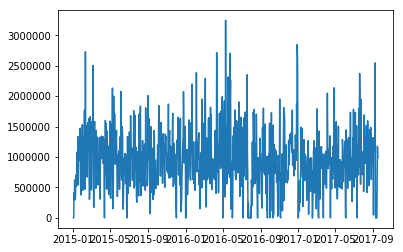

801061


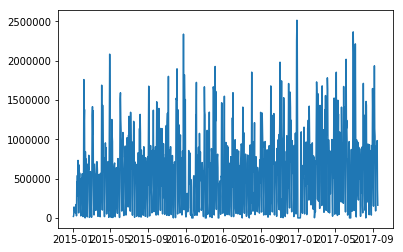

801096


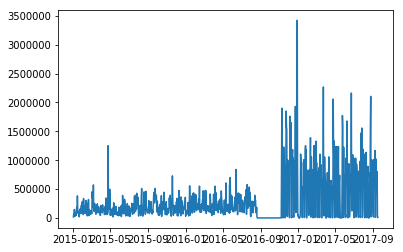

In [49]:
for ida in all_data.ATM_ID.unique()[:20]:
    print(ida)
    plt.plot(all_data[all_data.ATM_ID==ida]['Клиентский расход'])
    plt.show()

In [50]:
timeseries = all_data[all_data.ATM_ID == 869273]['Клиентский расход']

In [51]:
timeseries

2015-01-01          0.0
2015-01-02          0.0
2015-01-03          0.0
2015-01-04          0.0
2015-01-05          0.0
                ...    
2017-09-13    1176700.0
2017-09-14    2770800.0
2017-09-15    1510100.0
2017-09-16     756900.0
2017-09-17          0.0
Name: Клиентский расход, Length: 991, dtype: float64

In [52]:
X_train, X_test, y_train, y_test = prepare_data(timeseries, lags = [1,2,3], test_size=0.3)

In [53]:
X_test

lag_1      lag_2      lag_3  is_weekend  weekday_average  \
693   575300.0   773400.0   844500.0           1      2506.060606   
694        0.0   575300.0   773400.0           0    842487.878788   
695   531600.0        0.0   575300.0           0    874597.979798   
696  1026200.0   531600.0        0.0           0    998309.090909   
697   610300.0  1026200.0   531600.0           0    877286.868687   
..         ...        ...        ...         ...              ...   
983    85200.0  3124900.0        0.0           0    998309.090909   
984  1176700.0    85200.0  3124900.0           0    877286.868687   
985  2770800.0  1176700.0    85200.0           0    953266.666667   
986  1510100.0  2770800.0  1176700.0           1    782982.828283   
987   756900.0  1510100.0  2770800.0           1      2506.060606   

      hour_average  
693  761633.910534  
694  761633.910534  
695  761633.910534  
696  761633.910534  
697  761633.910534  
..             ...  
983  761633.910534  
984  761633.910534  
985  761633.910534  
986  761633.910534  
987  761633.910534  

[295 rows x 6 columns]

In [54]:
model = LinearRegression()

In [55]:
model.fit(X_train, y_train)

LinearRegression()

In [56]:
prediction = [(model.predict(X_test)[j] if model.predict(X_test)[j] > 0 else 0) for j in range(len(y_test))]

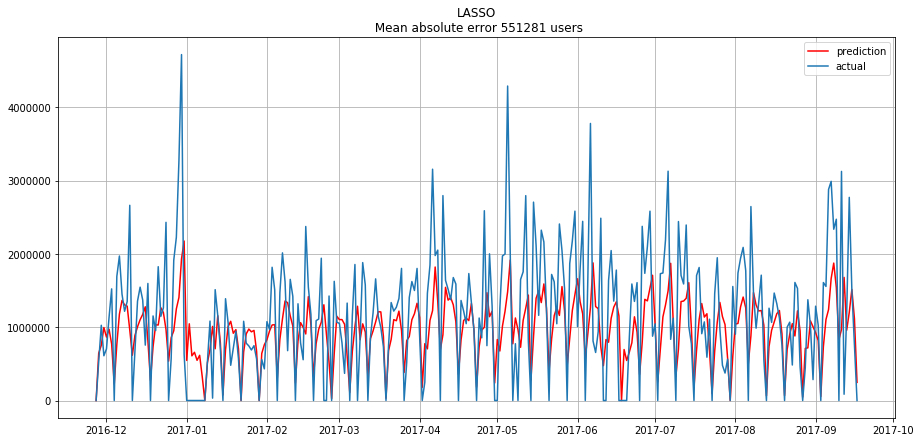

In [57]:
y_series_values = pd.Series(y_test.values, index=timeseries.index[-len(y_test.values):])
prediction_series = pd.Series(prediction, index=timeseries.index[-len(y_test.values):])
plt.figure(figsize=(15, 7))
plt.plot(prediction_series, "r", label="prediction")
plt.plot(y_series_values, label="actual")
plt.legend(loc="best")
plt.title("LASSO\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [58]:
timeseries=all_data[all_data.ATM_ID == 786676]['Клиентский расход']
X_train, X_test, y_train, y_test = prepare_data(timeseries, lags = [1,2,3], test_size=0.4)
model = LinearRegression()
model.fit(X_train, y_train)
prediction = [(model.predict(X_test)[j] if model.predict(X_test)[j] > 0 else 0) for j in range(len(y_test))]

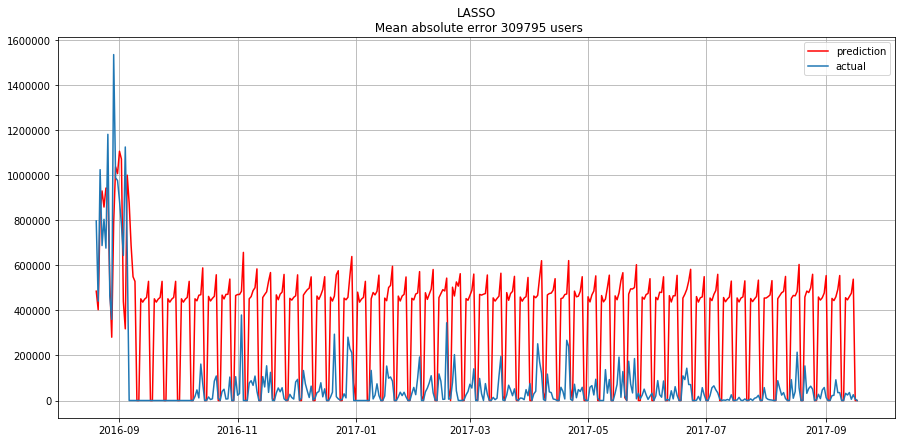

In [59]:
y_series_values = pd.Series(y_test.values, index=timeseries.index[-len(y_test.values):])
prediction_series = pd.Series(prediction, index=timeseries.index[-len(y_test.values):])
plt.figure(figsize=(15, 7))
plt.plot(prediction_series, "r", label="prediction")
plt.plot(y_series_values, label="actual")
plt.legend(loc="best")
plt.title("LASSO\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

Тут совсем все плохо как-то

__XGBoost__

In [60]:
import xgboost as xgb

def XGB_forecast(data, lags = [1,2,3], test_size=0.15, scale=1.96):
    
    # исходные данные
    X_train, X_test, y_train, y_test = prepare_data(dataset.Users, lags, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000
    
    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
    
    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())
    
    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])
    
    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]
    
    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)
    
    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

[20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: re

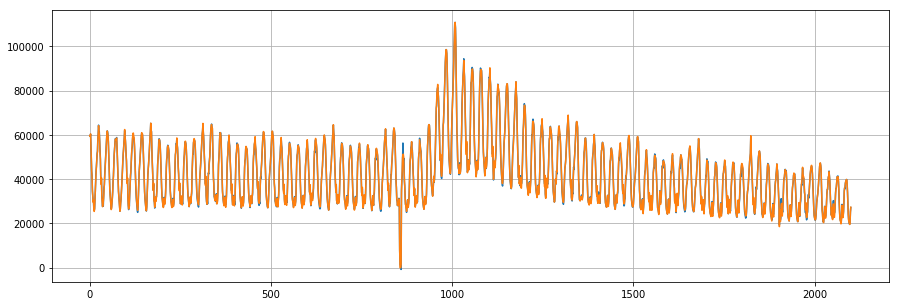

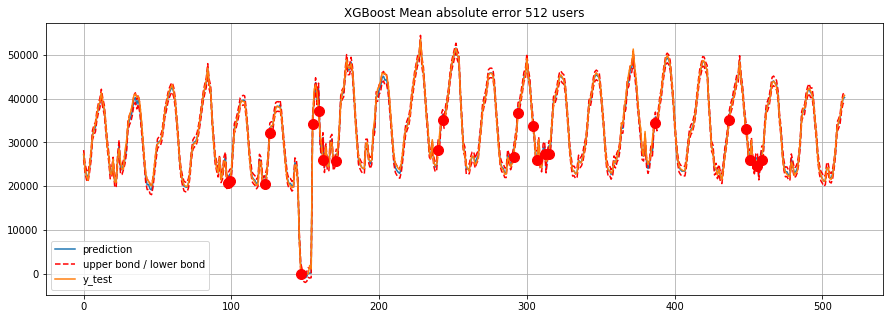

In [61]:
XGB_forecast(dataset, test_size=0.2, lags=range(10))

__Prophet__

In [2]:
import pandas as pd
from prophet import Prophet

$y(t) = g(t) + s(t) + h(t) + e$

In [3]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [4]:
data

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[4416 rows x 1 columns]

In [21]:
# приводим dataframe к нужному формату
df = data.reset_index()[['datetime', 'num_orders']]
df.columns = ['ds', 'y']

test_size = int(df.shape[0] * 0.1)
train_df = df[:-test_size]
test_df = df[-test_size:]

In [22]:
display(train_df)
test_df

ds    y
0    2018-03-01 00:00:00  124
1    2018-03-01 01:00:00   85
2    2018-03-01 02:00:00   71
3    2018-03-01 03:00:00   66
4    2018-03-01 04:00:00   43
...                  ...  ...
3970 2018-08-13 10:00:00  156
3971 2018-08-13 11:00:00  144
3972 2018-08-13 12:00:00   92
3973 2018-08-13 13:00:00  119
3974 2018-08-13 14:00:00  102

[3975 rows x 2 columns]

ds    y
3975 2018-08-13 15:00:00  175
3976 2018-08-13 16:00:00  144
3977 2018-08-13 17:00:00  152
3978 2018-08-13 18:00:00  104
3979 2018-08-13 19:00:00   91
...                  ...  ...
4411 2018-08-31 19:00:00  136
4412 2018-08-31 20:00:00  154
4413 2018-08-31 21:00:00  159
4414 2018-08-31 22:00:00  223
4415 2018-08-31 23:00:00  205

[441 rows x 2 columns]

In [24]:
m = Prophet()
m.fit(train_df)

11:08:58 - cmdstanpy - INFO - Chain [1] start processing
11:08:58 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future = m.make_future_dataframe(periods=test_size, freq='H')

In [33]:
future.tail(test_size)

ds
3975 2018-08-13 15:00:00
3976 2018-08-13 16:00:00
3977 2018-08-13 17:00:00
3978 2018-08-13 18:00:00
3979 2018-08-13 19:00:00
...                  ...
4411 2018-08-31 19:00:00
4412 2018-08-31 20:00:00
4413 2018-08-31 21:00:00
4414 2018-08-31 22:00:00
4415 2018-08-31 23:00:00

[441 rows x 1 columns]

In [34]:
future = m.make_future_dataframe(periods=test_size, freq='H')
forecast = m.predict(future)

In [35]:
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0    2018-03-01 00:00:00   54.819028   57.574340  124.348979    54.819028   
1    2018-03-01 01:00:00   54.824535   55.250587  118.091640    54.824535   
2    2018-03-01 02:00:00   54.830042   52.148679  116.217864    54.830042   
3    2018-03-01 03:00:00   54.835548   40.257474  102.182050    54.835548   
4    2018-03-01 04:00:00   54.841055   13.872996   77.004341    54.841055   
...                  ...         ...         ...         ...          ...   
4411 2018-08-31 19:00:00  125.378221   93.491325  155.230085   124.874218   
4412 2018-08-31 20:00:00  125.401633  100.853768  164.808594   124.895925   
4413 2018-08-31 21:00:00  125.425045  112.856544  178.823084   124.916268   
4414 2018-08-31 22:00:00  125.448457  129.443911  191.980334   124.936611   
4415 2018-08-31 23:00:00  125.471869  137.719780  198.245156   124.956954   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0       54.819028       34.115270             34.115270             34.115270   
1       54.824535       34.194453             34.194453             34.194453   
2       54.830042       30.313035             30.313035             30.313035   
3       54.835548       16.235526             16.235526             16.235526   
4       54.841055       -9.608461             -9.608461             -9.608461   
...           ...             ...                   ...                   ...   
4411   125.868891        0.005354              0.005354              0.005354   
4412   125.893659        7.094545              7.094545              7.094545   
4413   125.918428       21.964758             21.964758             21.964758   
4414   125.943197       34.926015             34.926015             34.926015   
4415   125.968742       41.171007             41.171007             41.171007   

          daily  daily_lower  daily_upper     weekly  weekly_lower  \
0     32.110804    32.110804    32.110804   2.004467      2.004467   
1     32.694546    32.694546    32.694546   1.499907      1.499907   
2     29.343283    29.343283    29.343283   0.969753      0.969753   
3     15.811674    15.811674    15.811674   0.423852      0.423852   
4     -9.480719    -9.480719    -9.480719  -0.127743     -0.127743   
...         ...          ...          ...        ...           ...   
4411 -11.902120   -11.902120   -11.902120  11.907474     11.907474   
4412  -4.787681    -4.787681    -4.787681  11.882226     11.882226   
4413  10.215718    10.215718    10.215718  11.749040     11.749040   
4414  23.417992    23.417992    23.417992  11.508023     11.508023   
4415  30.010420    30.010420    30.010420  11.160586     11.160586   

      weekly_upper  multiplicative_terms  multiplicative_terms_lower  \
0         2.004467                   0.0                         0.0   
1         1.499907                   0.0                         0.0   
2         0.969753                   0.0                         0.0   
3         0.423852                   0.0                         0.0   
4        -0.127743                   0.0                         0.0   
...            ...                   ...                         ...   
4411     11.907474                   0.0                         0.0   
4412     11.882226                   0.0                         0.0   
4413     11.749040                   0.0                         0.0   
4414     11.508023                   0.0                         0.0   
4415     11.160586                   0.0                         0.0   

      multiplicative_terms_upper        yhat  
0                            0.0   88.934298  
1                            0.0   89.018988  
2                            0.0   85.143077  
3                            0.0   71.071074  
4                            0.0   45.232594  
...                          ...         ...  
4411                         0.0  125.383575  
4412                         0.0  132.4961

In [38]:
predicts = forecast[['ds', 'yhat']].tail(test_size)
predicts.columns = ('ds', 'y')
predicts

ds           y
3975 2018-08-13 15:00:00  130.127434
3976 2018-08-13 16:00:00  135.079686
3977 2018-08-13 17:00:00  125.591497
3978 2018-08-13 18:00:00  110.608605
3979 2018-08-13 19:00:00  103.299352
...                  ...         ...
4411 2018-08-31 19:00:00  125.383575
4412 2018-08-31 20:00:00  132.496178
4413 2018-08-31 21:00:00  147.389803
4414 2018-08-31 22:00:00  160.374472
4415 2018-08-31 23:00:00  166.642876

[441 rows x 2 columns]

In [39]:
test_df

ds    y
3975 2018-08-13 15:00:00  175
3976 2018-08-13 16:00:00  144
3977 2018-08-13 17:00:00  152
3978 2018-08-13 18:00:00  104
3979 2018-08-13 19:00:00   91
...                  ...  ...
4411 2018-08-31 19:00:00  136
4412 2018-08-31 20:00:00  154
4413 2018-08-31 21:00:00  159
4414 2018-08-31 22:00:00  223
4415 2018-08-31 23:00:00  205

[441 rows x 2 columns]

In [48]:
import matplotlib.pyplot as plt
test_df = test_df.set_index('ds', drop=True)
predicts = predicts.set_index('ds', drop=True)

KeyError: "None of ['ds'] are in the columns"

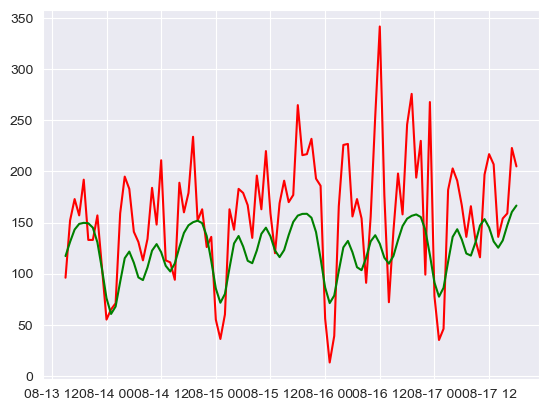

In [53]:
x = test_df.index[:100]
y = test_df.tail(100)
z = predicts.tail(100)

plt.plot(x, y, color = 'r')
plt.plot(x, z, color = 'g')
plt.show()

In [ ]:
d

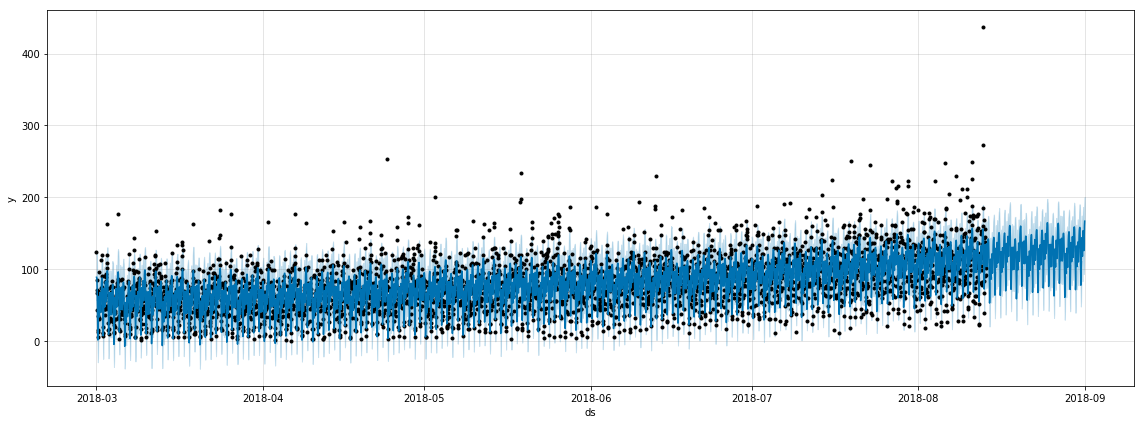

In [73]:
fig = m.plot(forecast, figsize=(16, 6))

In [74]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [75]:
df_joined = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
df_joined.head()

yhat  yhat_lower  yhat_upper    y
ds                                                         
2018-03-01 00:00:00  88.609249   56.761365  121.862739  124
2018-03-01 01:00:00  88.695516   58.005256  121.930250   85
2018-03-01 02:00:00  84.820850   54.367949  118.056226   71
2018-03-01 03:00:00  70.749939   38.667919  102.916587   66
2018-03-01 04:00:00  44.912678   14.192917   77.273247   43

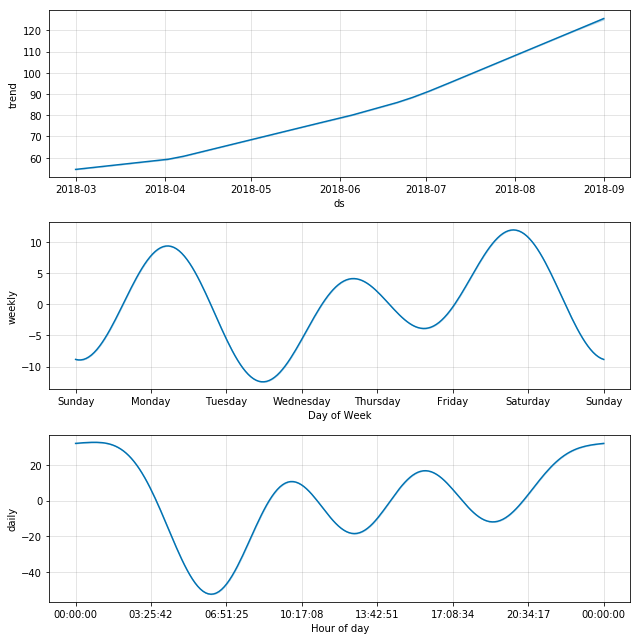

In [76]:
fig = m.plot_components(forecast)

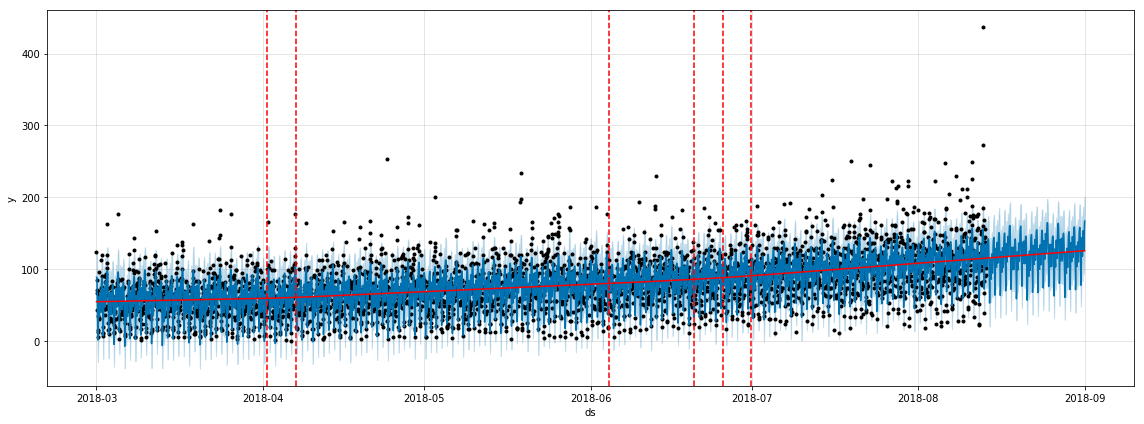

In [77]:
from prophet.plot import add_changepoints_to_plot

fig = m.plot(forecast, figsize=(16, 6))
# существенные изменение тренда
a = add_changepoints_to_plot(fig.gca(), m, forecast, threshold=0.01)

In [78]:
m.changepoints

127    2018-03-06 07:00:00
254    2018-03-11 14:00:00
381    2018-03-16 21:00:00
509    2018-03-22 05:00:00
636    2018-03-27 12:00:00
763    2018-04-01 19:00:00
890    2018-04-07 02:00:00
1017   2018-04-12 09:00:00
1144   2018-04-17 16:00:00
1272   2018-04-23 00:00:00
1399   2018-04-28 07:00:00
1526   2018-05-03 14:00:00
1653   2018-05-08 21:00:00
1780   2018-05-14 04:00:00
1907   2018-05-19 11:00:00
2035   2018-05-24 19:00:00
2162   2018-05-30 02:00:00
2289   2018-06-04 09:00:00
2416   2018-06-09 16:00:00
2543   2018-06-14 23:00:00
2670   2018-06-20 06:00:00
2798   2018-06-25 14:00:00
2925   2018-06-30 21:00:00
3052   2018-07-06 04:00:00
3179   2018-07-11 11:00:00
Name: ds, dtype: datetime64[ns]

Добавим учет праздников

In [79]:
m = Prophet(weekly_seasonality=20)
m.add_country_holidays(country_name='RU')
m.fit(train_df)

future = m.make_future_dataframe(periods=test_size, freq='H')
forecast = m.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


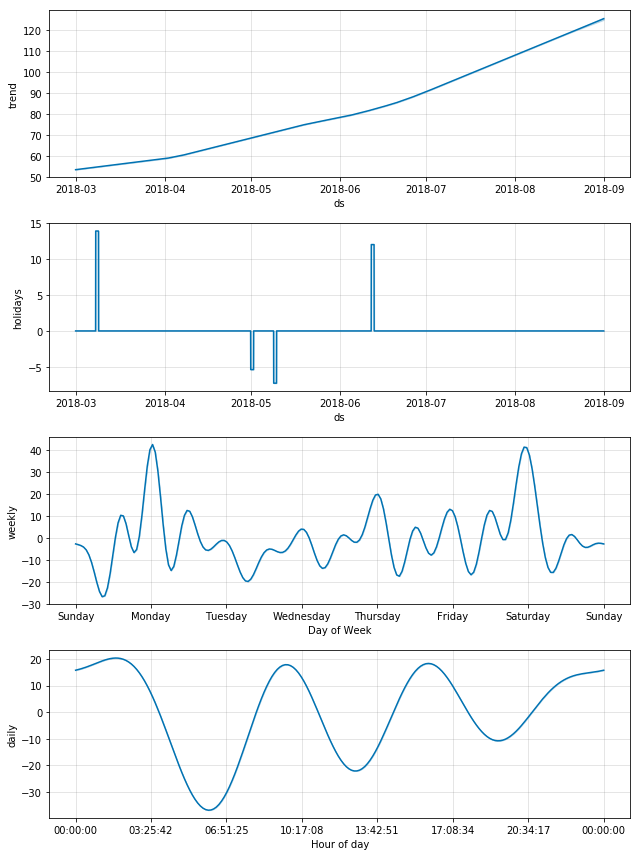

In [80]:
fig = m.plot_components(forecast)